In [1]:
%load_ext autoreload
%autoreload 2
import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models import ExactGPModel, SGDGPModel

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

/home/shreyaspadhy_gmail_com/.local/lib/python3.8/site-packages/jax/_src/api_util.py:183: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


## Generate Data

In [52]:
noise_scale = 0.5
n_data = 5000

# data_train, data_test = data.get_concentrating_toy_sin_dataset(
#     seed=3,
#     n=n_data,
#     noise_scale=noise_scale,
#     n_test=100,
#     normalise=False
# )

data_train, data_test = data.get_expanding_toy_sin_dataset(
    seed=3,
    n=n_data,
    noise_scale=noise_scale,
    n_test=100,
    normalise=False
)



## ExactGP Model

(100,) (100,)


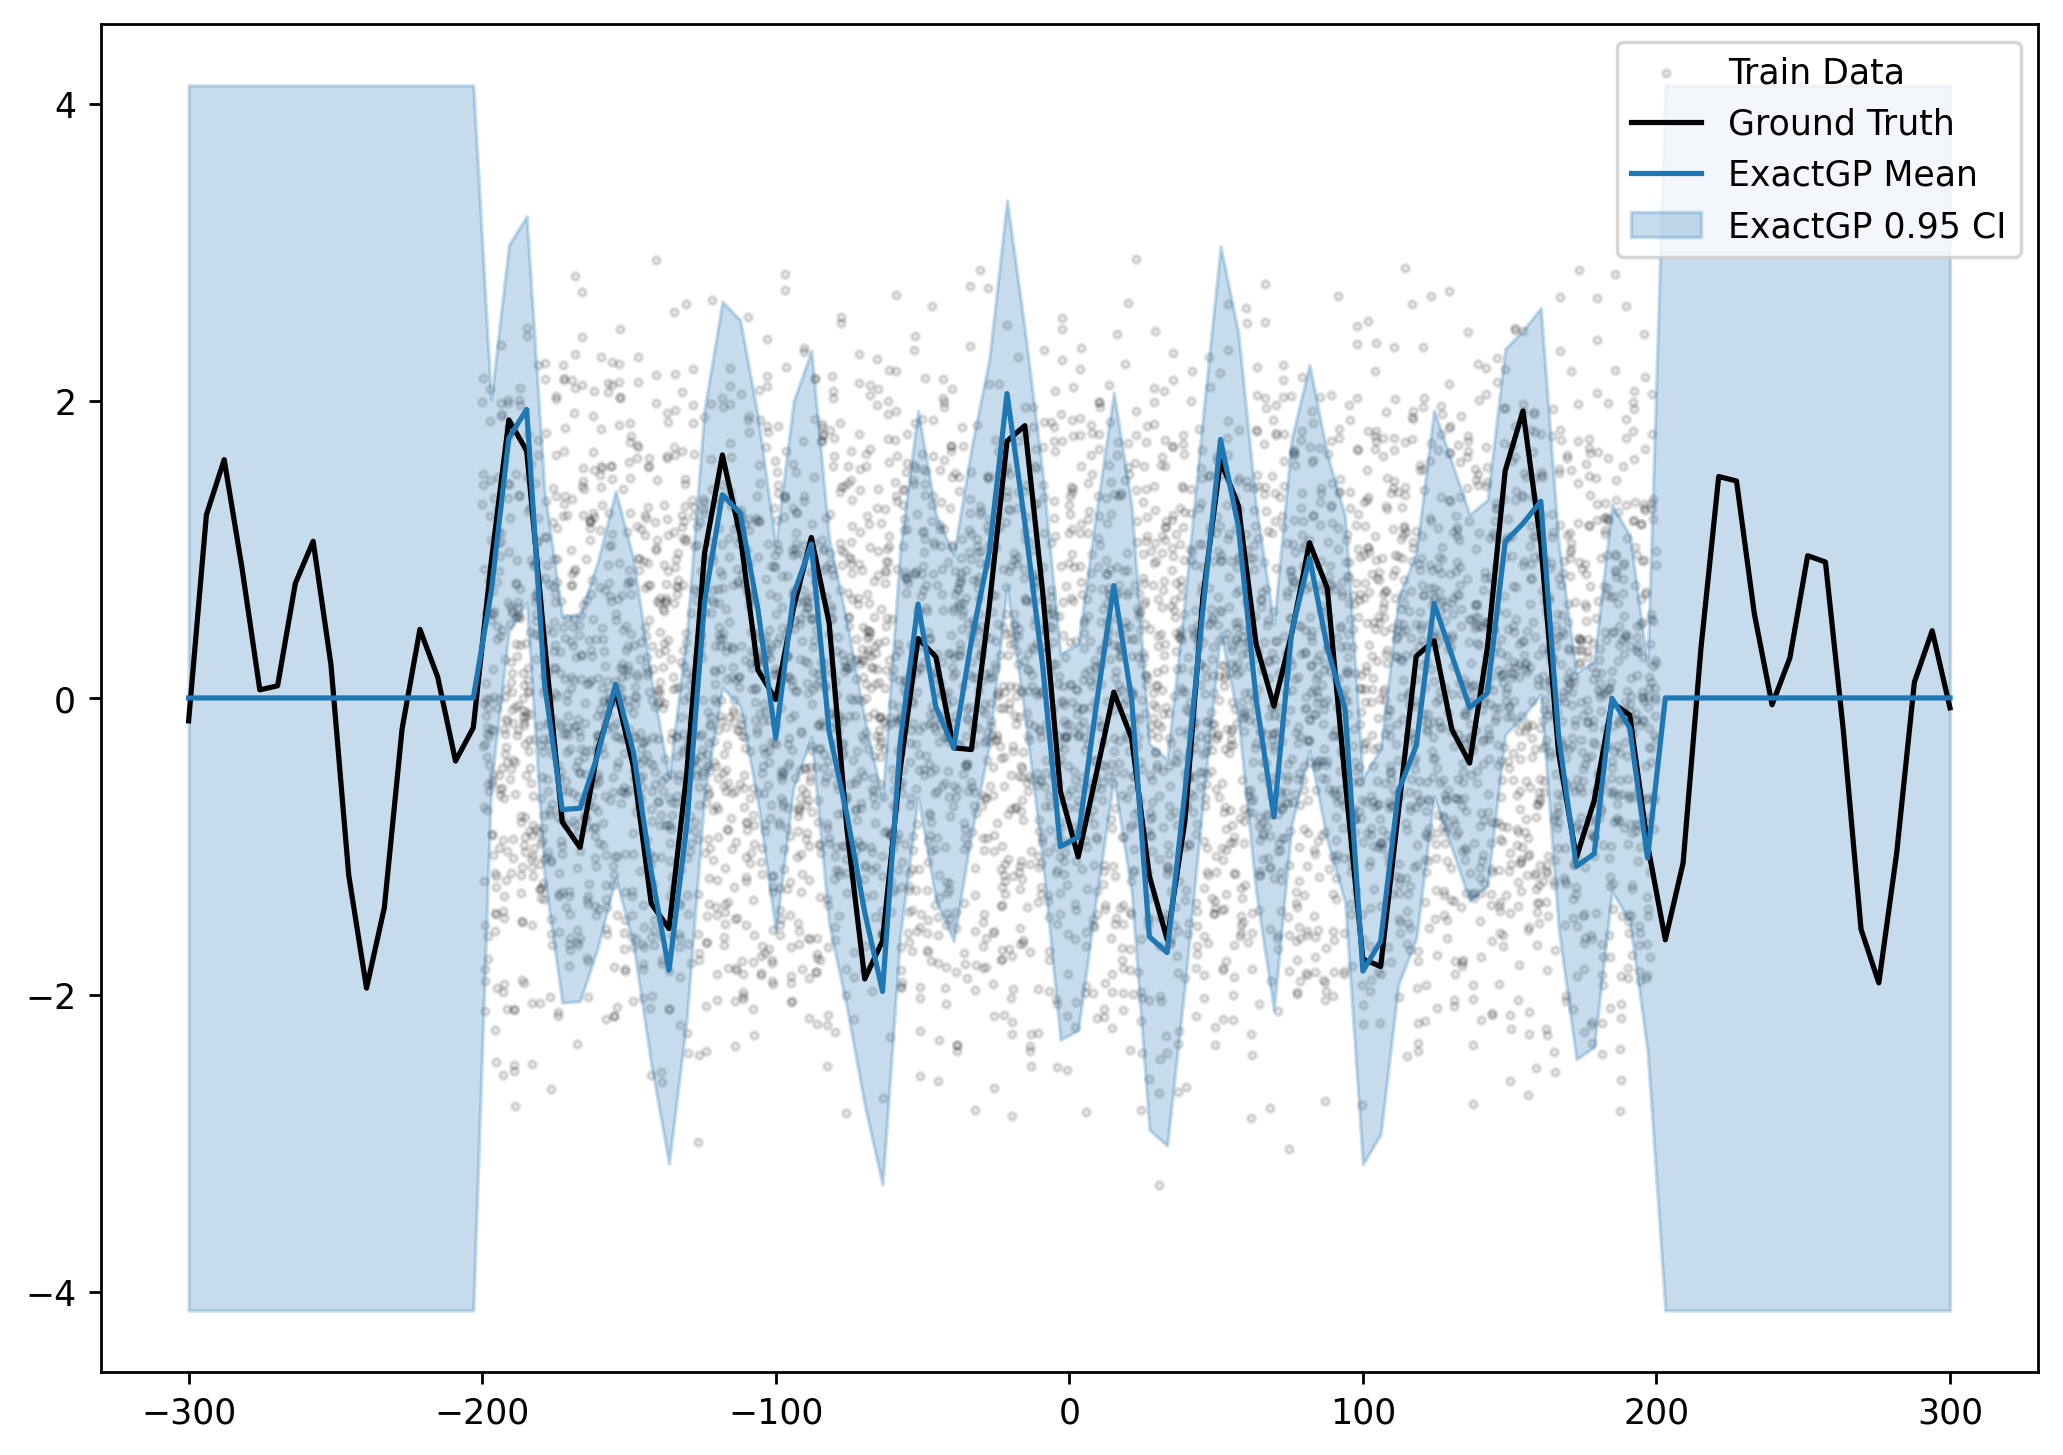

In [53]:
kernel_config = {
    'signal_scale': 2.,
    'length_scale': 0.1,
}

kernel = RBFKernel(kernel_config=kernel_config)

exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)

exact_gp.compute_representer_weights(data_train)
exact_pred_mean = exact_gp.predictive_mean(data_train, data_test)

exact_pred_var = exact_gp.predictive_variance(data_train, data_test) + noise_scale ** 2
exact_pred_std = jnp.sqrt(exact_pred_var)

print(exact_pred_mean.shape, exact_pred_var.shape)

plt.figure(dpi=250, figsize=[10, 7])
plt.scatter(data_train.x, data_train.y, 5, label='Train Data', alpha=0.1, color='k')
plt.plot(data_test.x, data_test.y, alpha=1., color='k', label='Ground Truth')
plt.plot(data_test.x, exact_pred_mean, color='tab:blue', label='ExactGP Mean')
plt.fill_between(data_test.x.squeeze(),
                 exact_pred_mean - 2 * exact_pred_std,
                 exact_pred_mean + 2 * exact_pred_std,
                 alpha=0.25, color='tab:blue', label='ExactGP 0.95 CI')
# plt.xlim([-5, 5])
plt.legend()

### ExactGP (samples)

In [54]:
base_key = jax.random.PRNGKey(0)

zero_mean_posterior_samples, alpha_samples_exact = exact_gp.compute_zero_mean_samples(
    base_key, 
    n_samples=25,
    train_ds=data_train,
    test_ds=data_test,
    n_features=250,
    use_rff=True
)

exact_pred_var_samples = exact_gp.predictive_variance_samples(zero_mean_posterior_samples) + noise_scale ** 2
exact_pred_std_samples = jnp.sqrt(exact_pred_var_samples)

print(f'zero_mean_posterior_samples.shape: {zero_mean_posterior_samples.shape}')
print(f'alpha_samples_exact.shape: {alpha_samples_exact.shape}')


zero_mean_posterior_samples.shape: (25, 100)
alpha_samples_exact.shape: (25, 5000)


# SGDGP

In [55]:
import ml_collections
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.learning_rate = 1e-4
config.train_config.momentum = 0.9
config.train_config.polyak = 1e-3
config.train_config.iterations = int(5e4)
config.train_config.batch_size = 20
config.train_config.eval_every = 100
config.train_config.num_features = 250
config.train_config.recompute_features = True

sgd_gp = SGDGPModel(noise_scale=noise_scale, kernel=kernel)

optim_key = jax.random.PRNGKey(1)

metrics = ["loss", "alpha_diff", "y_pred_diff", "hilbert_err"]
compare_exact_vals = [
    exact_gp.compute_representer_weights(data_train), exact_pred_mean, None, None, None ]

alpha_polyak, info = sgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=data_train, 
    test_ds=data_test,
    config=config.train_config,
    metrics=metrics,
    compare_exact_vals=compare_exact_vals
)



100%|██████████| 50000/50000 [00:27<00:00, 1807.96it/s]


In [57]:
sampling_key = jax.random.PRNGKey(2)

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config.learning_rate = 1e-4
config.sampling_config.momentum = 0.9
config.sampling_config.polyak = 1e-1
config.sampling_config.iterations = int(1e4)
config.sampling_config.batch_size = 20
config.sampling_config.eval_every = 100
config.sampling_config.num_features_prior_sample = 200
config.sampling_config.num_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 2


sgd_pred_mean = sgd_gp.predictive_mean(data_train, data_test)

zero_mean_samples, alpha_samples = sgd_gp.compute_zero_mean_samples(
    sampling_key, 
    n_samples=25,
    train_ds=data_train,
    test_ds=data_test,
    config=config.sampling_config,
    sampling_metrics=[],
    use_rff=True,
    compare_exact_vals=None,
)

print(f'zero_mean_samples : {zero_mean_samples.shape}')
print(f'alpha_samples : {alpha_samples.shape}')

100%|██████████| 10000/10000 [01:11<00:00, 140.54it/s]


zero_mean_samples : (25, 100)
alpha_samples : (25, 5000)


In [58]:
sgd_pred_var_samples = sgd_gp.predictive_variance_samples(zero_mean_samples) + noise_scale ** 2
sgd_pred_std_samples = jnp.sqrt(sgd_pred_var_samples)

print()
print(f'sgd_pred_std_samples.shape: {sgd_pred_std_samples.shape}')


sgd_pred_std_samples.shape: (100,)


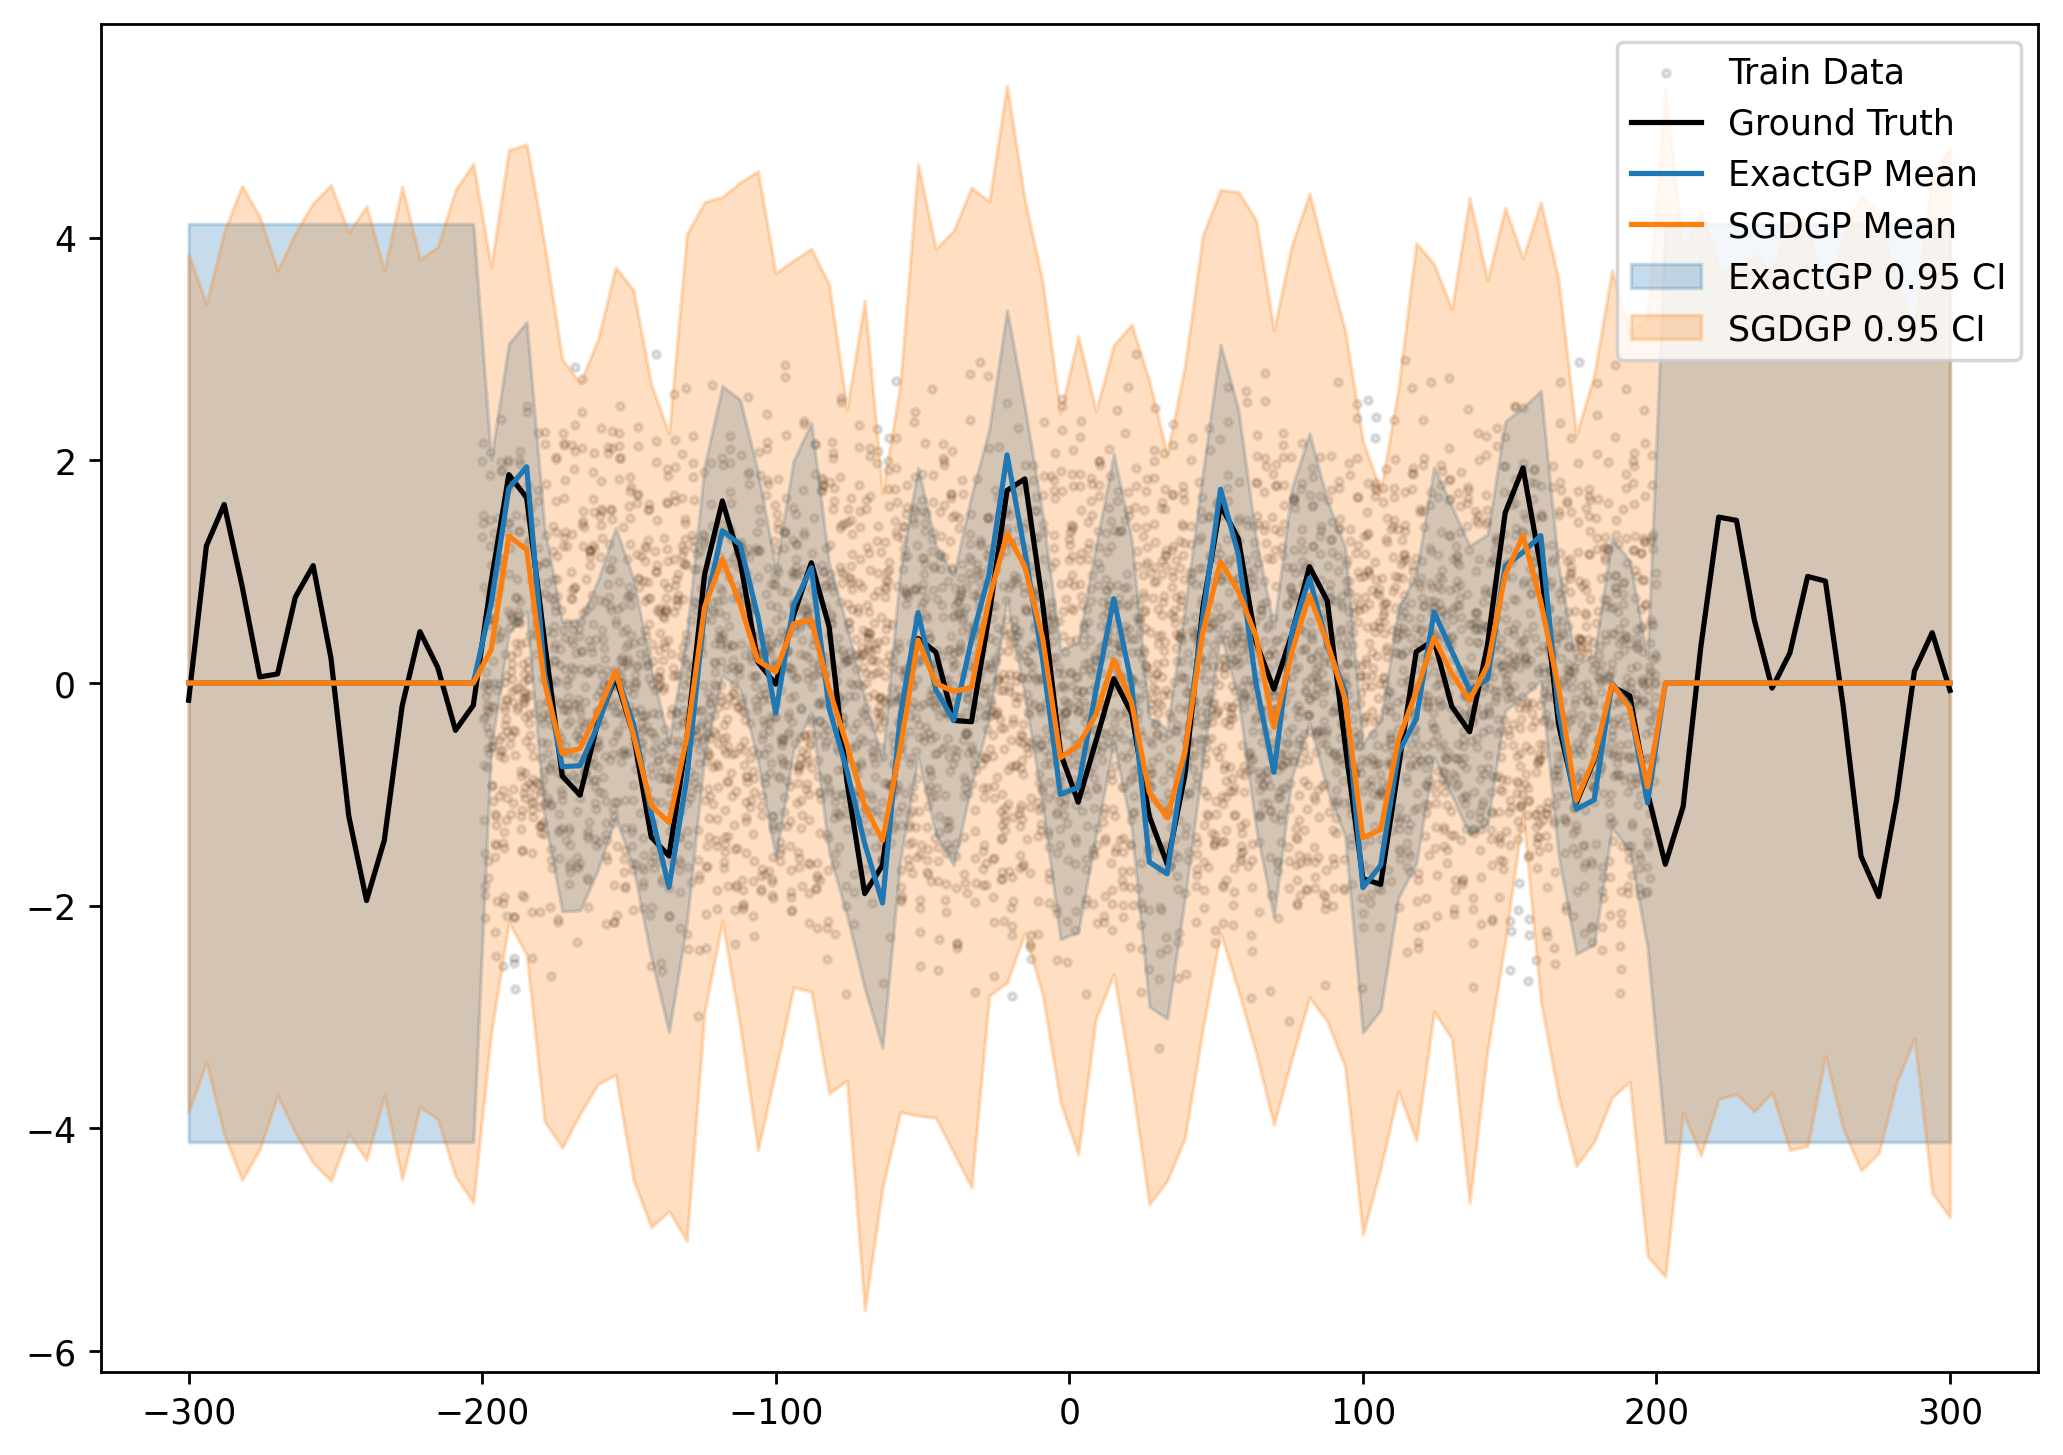

In [62]:
plt.figure(dpi=250, figsize=[10, 7])
plt.scatter(data_train.x, data_train.y, 5, label='Train Data', alpha=0.1, color='k')
plt.plot(data_test.x, data_test.y, alpha=1., color='k', label='Ground Truth')
plt.plot(data_test.x, exact_pred_mean, color='tab:blue', label='ExactGP Mean')
plt.plot(data_test.x, sgd_pred_mean, label='SGDGP Mean', color='tab:orange')
# plt.fill_between(data_test.x.squeeze(),
#                  exact_pred_mean - 2 * exact_pred_std_samples,
#                  exact_pred_mean + 2 * exact_pred_std_samples,
#                  alpha=0.1,
#                  color='tab:green',
#                  label='ExactGP (RFF samples) 0.95 CI')
plt.fill_between(data_test.x.squeeze(),
                 exact_pred_mean - 2 * exact_pred_std,
                 exact_pred_mean + 2 * exact_pred_std,
                 alpha=0.25, color='tab:blue', label='ExactGP 0.95 CI')
plt.fill_between(data_test.x.squeeze(),
                 sgd_pred_mean - 2 * sgd_pred_std_samples,
                 sgd_pred_mean + 2 * sgd_pred_std_samples,
                 alpha=0.25, color='tab:orange', label='SGDGP 0.95 CI')
# plt.xlim([-5, 5])
plt.legend()